# Problem 1

Setting up the enrivonment and loading the data. No need to change this part.

In [40]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# Load tensors from the file
loaded_tensors = torch.load('exercise_2_problem_1_data.pth')
X_tensor = loaded_tensors['X_tensor']
Y_tensor = loaded_tensors['Y_tensor']
dataset = TensorDataset(X_tensor, Y_tensor)

## a) Model definition

Finalize the model definition as instructed in the exercise sheet.

In [41]:
class RegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 400),
            nn.ReLU(),
            nn.Linear(400, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, output_dim)
        )

    def forward(self, x):
        return self.layers(x)


## b) Write optimization loop

You can use any optimizer you want, but remember to set all the hyperparameters it requires, including the batch size and number of iterations etc that are defined outside the optimizer function.

In [151]:
# Helper for retrieving minibatches of desired size
device = "cuda" if torch.cuda.is_available() else "cpu"

batch_size = 64
print(f"Batch size is {batch_size}")

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


model = RegressionModel(100, 2).to(device)
criterion = nn.MSELoss()
lr = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
print(f"Optimizer is {optimizer}\n")

num_epochs = 200
printing_interval = num_epochs // 10 # Avoid printing hundreds or thousands of losses, to keep the notebook cleaner
losses_ = []

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0

    for x_batch, y_batch in dataloader:
        # send only the current batch to GPU (if available)
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_batch, y_pred)
        loss.backward()
        optimizer.step()

        # 1) TODO: Zero the gradients
        # 2) TODO: Forward pass
        # 3) TODO: Compute loss (MSE)
        # 4) TODO: Backprop
        # 5) TODO: Update parameters

        running_loss += loss.item()

    avg_loss = running_loss / len(dataloader)
    losses_.append(avg_loss)

    if (epoch % printing_interval == 1):
        print(f"Epoch [{epoch+1}/{num_epochs}] - MSE Loss: {avg_loss:.6f}")

    if avg_loss < 1e-6:
        #print(f"Loss threshold of < 1e-6 reached after epoch {epoch}")
        break
print(f"Final MSE Loss {losses_[-1]} after {len(losses_)} epochs")

Batch size is 64
Optimizer is Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)

Epoch [2/200] - MSE Loss: 0.962191
Epoch [22/200] - MSE Loss: 0.227353
Epoch [42/200] - MSE Loss: 0.080137
Epoch [62/200] - MSE Loss: 0.024274
Epoch [82/200] - MSE Loss: 0.006655
Epoch [102/200] - MSE Loss: 0.001527
Epoch [122/200] - MSE Loss: 0.000298
Epoch [142/200] - MSE Loss: 0.000048
Epoch [162/200] - MSE Loss: 0.000006
Final MSE Loss 9.580040725154504e-07 after 180 epochs


## d) Computing the gradient norms

Practice extracting information about a trained model, by computing the gradient norms that were used to analyse SGD behavior during the lectures. No need to do anything with the gradient norms, just show that you can compute them.

In [152]:
# Switch to evaluation mode -- we are no longer training!
model.eval()

grad_norms = []  # to store gradient norms for each batch

for x_batch, y_batch in dataloader:
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    #optimizer.zero_grad()
    y_pred = model(x_batch)

    loss = criterion(y_batch, y_pred)
    loss.backward()
    
    batch_norm = 0
    for p in model.parameters():
        p_norm = torch.linalg.norm(p.grad)
        batch_norm += p_norm.item()**2
# TODO: Define loop over batches
    # Compute squared L2 norm across all model parameter gradients
    # Hints:
    # - You again need to first evaluate the gradient of the loss wrt to the model parameters
    # - You can extract a list of all model parameters with model.parameters()
    # - For each parameter p in model.parameters(), you can access the gradient with p.grad
    grad_norms.append(batch_norm)

# Convert to numpy array for statistics
grad_norms = np.array(grad_norms)
mean_gn = grad_norms.mean()
var_gn  = grad_norms.var()

print("Gradient Norm stats for evaluation pass:")
print(f"  Mean  : {mean_gn:.6f}")
print(f"  Std   : {var_gn:.6f}")

Gradient Norm stats for evaluation pass:
  Mean  : 0.000956
  Std   : 0.000001


## e) Reporting

**Edit this cell directly to write your answers.** You should print the values within the code blocks, but also copy them here for ease of grading. You can also write any other remarks you may have in this cell.

### Optimizer settings: 
I used Adam with with a stepsize of $\mu = 0.0001$ and the rest kept at default values, i.e. $\beta_1 = 0.9$, $\beta_2=0.999$, $\epsilon = 10^{-8}$. The batch size was $B = 64$.

### Optimization speed:

I reached the loss threshold of $10^{-6}$ after $185$ epochs.

### The gradient norms:

After training the model, the gradient norm is $0.174203$ and the variance over the batches is $0.000108$.

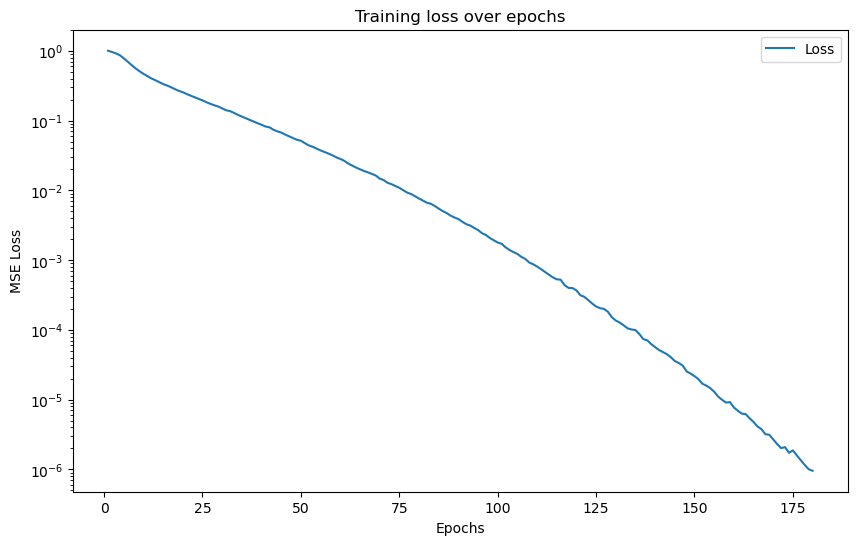

In [153]:
plt.figure(figsize=(10,6))
plt.semilogy(range(1, len(losses_) + 1), losses_, label="Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("Training loss over epochs")
plt.show()

=========

# Problem 2

## a) Generate training/testing data

Do not change this part. The code snippet greates synthetic data by feeding random inputs through randomly initialized neural network.

In [154]:
# N samples with D inputs and O outputs
N = 100
D = 10
O = 5

# Random mapping from x to y, as small neural network
class CreationModel(nn.Module):
  def __init__(self, D, O, M):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(D, M),
      nn.Tanh(),
      nn.Linear(M, O)
    )

  def forward(self, x):
    return self.layers(x)

# For getting the same data
torch.manual_seed(78798)

# Training data
x = torch.randn(N, D)
noiselevel = 0.1
modelGenerate = CreationModel(D,O,5)
modelGenerate.eval()
y = modelGenerate(x).clone().detach() + noiselevel*torch.randn(N, O)

# Test data
N_test = 10000
x_test = torch.randn(N_test, D)
y_test = modelGenerate(x_test).clone().detach()  + noiselevel*torch.randn(N_test, O)

## Pre-defined model

Do not change this part. The parameter $M$ controls the size/complexity of the network.

In [155]:
class RegressionModel(nn.Module):
  def __init__(self, D, O, M):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(D, M),
      nn.ReLU(),
      nn.Linear(M, M),
      nn.ReLU(),
      nn.Linear(M, O)
    )

  def forward(self, x):
    return self.layers(x)

## b) Train model and validate the double descent principle

In [ ]:
# Use full data for gradients
B = N
data_loader = DataLoader(TensorDataset(x,y), batch_size=B, shuffle=True)

# Loop over some range of M values. With these parameters logspace generates M=2 twice, so dropping the first entry
Mvalues = np.logspace(np.log10(2),np.log10(60),num=15,dtype='int')[1:]
losses = np.zeros((len(Mvalues),2))
for M_index, M in enumerate(Mvalues):
    # TODO: Define the model
    # TODO: Train it until convergence
    # TODO: Evaluate both training and test error, and store them

    losses[mi,0] = trainloss.item()
    losses[mi,1] = testloss.item()

### Plot the final training loss and the final test loss

The code below is provided as an example; you may need to modify it to be compatible with your results. Make some effort to make the plot easy to read.

In [ ]:
plt.loglog(Mvalues, losses[:,0], 'b-')
plt.loglog(Mvalues, losses[:,1], 'b:')
plt.legend(['Training loss', 'Test loss'])
ax = plt.gca(); ax.set_ylim([10**(-5),10**(0)])
ax.set_ylabel("MSE")
ax.set_xlabel("Number of neurons")
# Customize x-axis to show more detailed labels
from matplotlib.ticker import LogLocator, ScalarFormatter
ax.xaxis.set_major_locator(LogLocator(base=10.0, subs=np.arange(1, 10)))
ax.xaxis.set_major_formatter(ScalarFormatter())
plt.show()

### c) Having more data can hurt

Show that increasing the amount of data helps when around the interpolation threshold, but that for overparameterized model it may hurt.

In [ ]:
# Generate the larger training set, using the same process as before
N_large = 500
x_large = torch.randn(N_large, D)
y_large = modelGenerate(x_large).clone().detach() + noiselevel*torch.randn(N_large, O)

# TODO: Identify two values of M you need to answer the question

# TODO: Repeat the training process for those options. Note that you can use the same code as before, 
# since you only changed the data and the set of M

print("Test losses")
# TODO

## Reporting

**Edit this cell directly to report the requested information.**

### Interpolation threshold

TODO: The interpolation threshold is around M = ...

TODO: For that M, the model has in total ... parameters

TODO: Explain the findings. Do you observe the expected pattern? If not, what might have been a problem?

### More data can hurt

TODO: Explain your choices of M values, report the test errors for the different amounts of training data, and explain the findings.